In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import pandas as pd

print(torch.__version__)
print(torchaudio.__version__)

2.0.1
2.0.2


In [2]:
metadata = torchaudio.info("/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/test_1.wav")
print(metadata)

RuntimeError: Failed to fetch metadata from /Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/test_1.wav

In [3]:
waveform, sample_rate = torchaudio.load("/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/major/Test__1.wav")

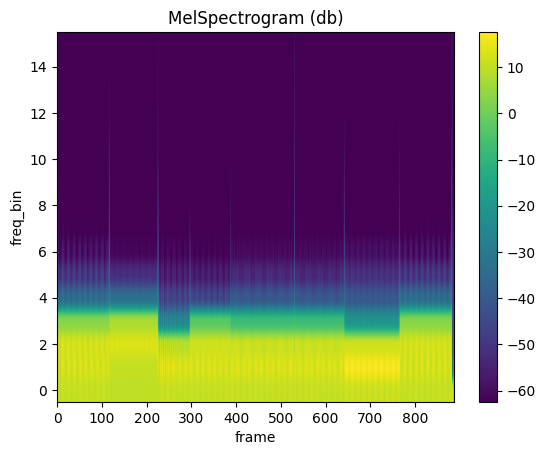

In [34]:
transform = torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_mels=16)
mel_specgram = transform(waveform)
mel_specgram
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "MelSpectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
plot_spectrogram(mel_specgram[0])

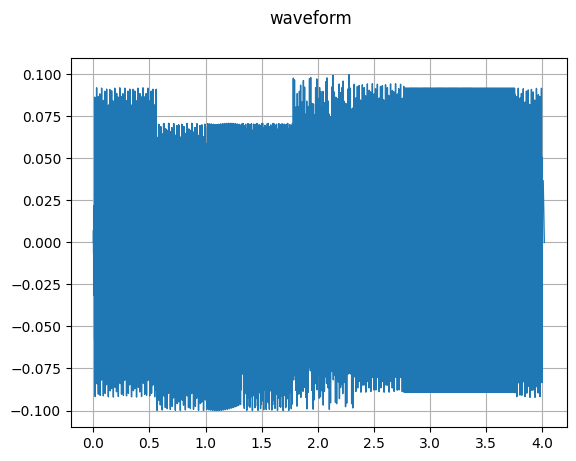

In [14]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
plot_waveform(waveform, sample_rate)

In [35]:
waveform, sample_rate = torchaudio.load("/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/minor/test_1.wav")

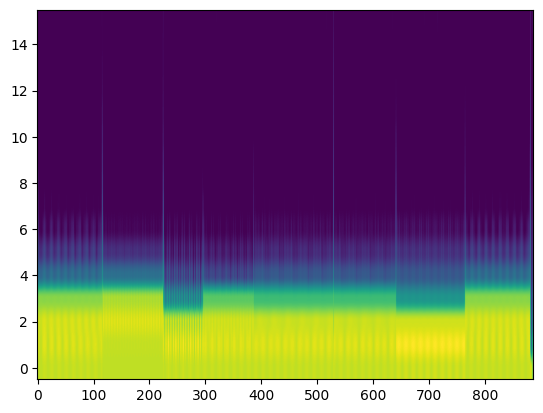

torch.Size([1, 16, 887])


In [4]:
transform = torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_mels=16)
mel_specgram = transform(waveform)
mel_specgram
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    #axs.set_title(title or "MelSpectrogram (db)")
    #axs.set_ylabel(ylabel)
    #axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    #fig.colorbar(im, ax=axs)
    plt.show(block=False)
plot_spectrogram(mel_specgram[0])
print(mel_specgram.size())

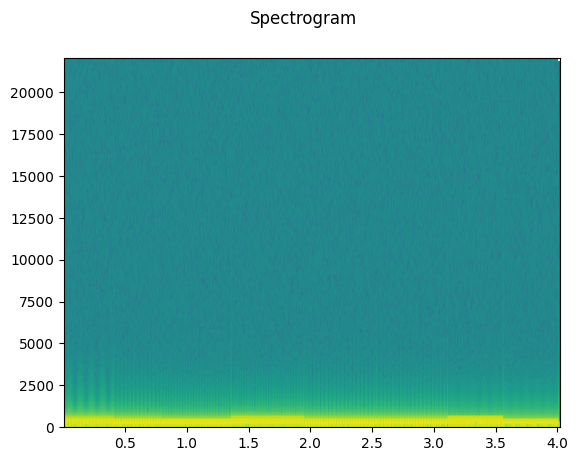

In [20]:
plot_specgram(waveform, sample_rate)

In [62]:
# write metadata file
from os import listdir
from os.path import isfile, join
train_path = "/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/train_data"
test_path = "/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/test_data"


train_files = sorted([f for f in listdir(train_path) if isfile(join(train_path, f))])
train_label = [int(name[0].islower()) for name in train_files]

test_files = sorted([f for f in listdir(test_path) if isfile(join(test_path, f))])
test_label = [int(name[0].islower()) for name in test_files]

train_df = pd.DataFrame({'filename': train_files,
                   'label': train_label})
test_df = pd.DataFrame({'filename': test_files,
                   'label': test_label})

print(train_df)
train_df.to_csv("/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/metadata_train.csv", sep='\t',\
          index=False)
test_df.to_csv("/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/metadata_test.csv", sep='\t',\
          index=False)

            filename  label
0        Test__0.wav      0
1        Test__1.wav      0
2       Test__10.wav      0
3      Test__100.wav      0
4     Test__1000.wav      0
...              ...    ...
2595    test_995.wav      1
2596    test_996.wav      1
2597    test_997.wav      1
2598    test_998.wav      1
2599    test_999.wav      1

[2600 rows x 2 columns]


In [63]:
# define torch customer dataset
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

class SoundDS(Dataset):
    def __init__(self, df, data_path, transform=torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_mels=16)):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 1
        self.transform = transform
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, idx):
        audio_file = self.data_path + self.df.loc[idx, 'filename']
        label = self.df.loc[idx, 'label']
        waveform, sample_rate = torchaudio.load(audio_file)
        specgram = self.transform(waveform)
        return (specgram, label)

In [73]:
from torch.utils.data import random_split

metadata_train = "/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/metadata_train.csv"
df = pd.read_csv(metadata_train, sep='\t')
data_path = "/Users/chia-hsinlin/Documents/Imperial/individual_project/msc_project/tempsnd/train_data/"
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)